<a href="https://colab.research.google.com/github/CoryLaidlaw/fastai_tutorial_notes/blob/main/Data_Block_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a DataBlock

In [1]:
from fastai.data.all import *
from fastai.vision.all import *

Looking at how to use the DataBlock API

## Get Data

In [2]:
path = untar_data(URLs.PETS)

In [4]:
fnames = get_image_files(path/"images")

## DataBlock

### Inputs and Targets

Starting with an empty DataBlock

In [6]:
dblock = DataBlock()

DataBlock is a blueprint on how to assemble data, it doesn't do anything until you pass it a source. Then you choose to convert the source into DataSets or DataLoaders. Due to not doing anything to get the data ready for batches, dataloaders method will fail. Instead use datasets method

In [7]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_27.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_27.jpg'))

By default the data block API assumes there is an input and a target, hence why the filename is repeated

Using get_items to assemble items in the data block

In [8]:
dblock = DataBlock(get_items=get_image_files)

The difference is that the folder is passed with images as a source and not the filenames

In [10]:
dsets = dblock.datasets(path/"images")
dsets.train[0]

(Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_153.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_153.jpg'))

Inputs are ready to be built as images, but the target is not. Since this is for the cat vs dog problem, convert the filename to a 'cat vs 'dog' (or True vs False)

In [12]:
def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

Then use it as a label by passing get_y

In [13]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path/"images")
dsets.train[0]

(Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_123.jpg'), 'dog')

Now that inputs and targets are ready, specify types to tell data block API that inputs are images and targets are categories.types are represented by blocks.

In [14]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path/"images")
dsets.train[0]

(PILImage mode=RGB size=400x300, TensorCategory(0))

DataBlock automatically adds the transforms needed to open the image and changes 'cat', to index 0. It created a mapping from categories to the index calle 'vocab' that can be accessed

In [15]:
dsets.vocab

['cat', 'dog']

Any block can be mixed and matched for inputs and targets. Multiple blocks can be needed if there is multiple inputs and/or targets by passing n_inp to tell library how many inputs (the rest would be targets) and passing a list of functions to get_x and/or get_y (to explain how to process each item and to be ready for this type)

### Validation

Next step is to control how the validation set is created by passing a splitter to DataBlock.

In [16]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter())

dsets = dblock.datasets(path/"images")
dsets.train[0]

(PILImage mode=RGB size=184x250, TensorCategory(0))

### Transforms & Batching

Specifing item transforms and batch transforms

In [17]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

With the resize items can be batched together and DataBlock can be converted into a DataLoader

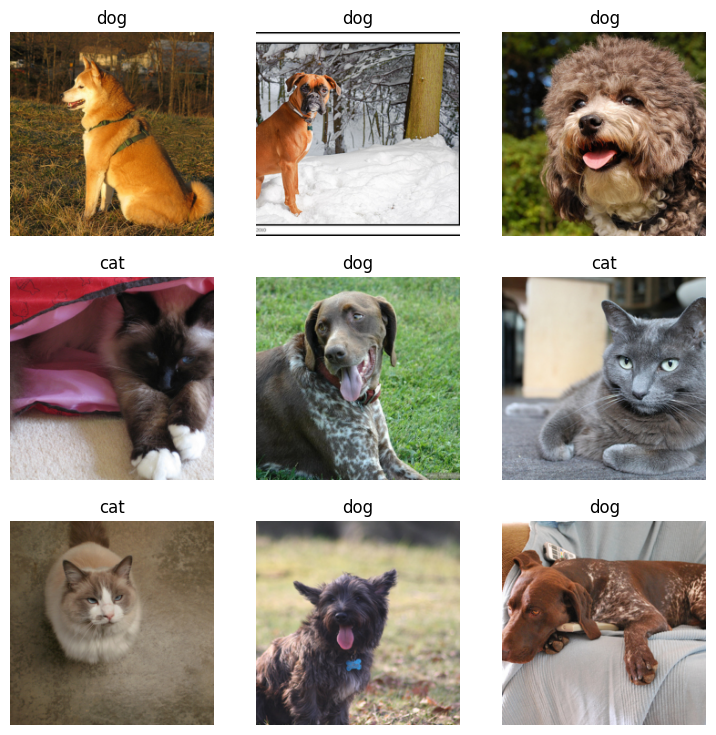

In [18]:
dls = dblock.dataloaders(path/"images")
dls.show_batch()

## Conclusion

Questions to answer for building DataBlock:

* What is the types of your inputs/targets?  (blocks =)
* Where is your data? (get_items =)
* Does something need to be applied to inputs? (get_x =)
* Does something need to be applied to the target? (get_y =)
* How to split the data? (splitter =)
* Do we need to apply something on formed items? (item_tfms =)
* Do we need to apply something on formed batches? (batch_tfms)

Which gives the following design:

dblock = DataBlock(blocks     = ,
                   get_items  = ,
                   get_x      = ,
                   get_y      = ,
                   splitter   = ,
                   item_tfms  = ,
                   batch_tfms = )

# Image Classification

In [19]:
from fastai.vision.all import *

## Single Label

Using MNIST (dataset of handwritten digits 0-9)

Using questions to build DataBlock:
* What is the types of your inputs/targets?  (blocks =)
  * b&w images and labels
* Where is your data? (get_items =)
  * subfolders
* Does something need to be applied to the target? (get_y =)
  * parent folder
* How to split the data? (splitter =)
  * grandparent folder

API:

In [20]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

DataBlock is just a blueprint, it doesn't do anything or check for errors, it needs to be fed the data source to actually gather something

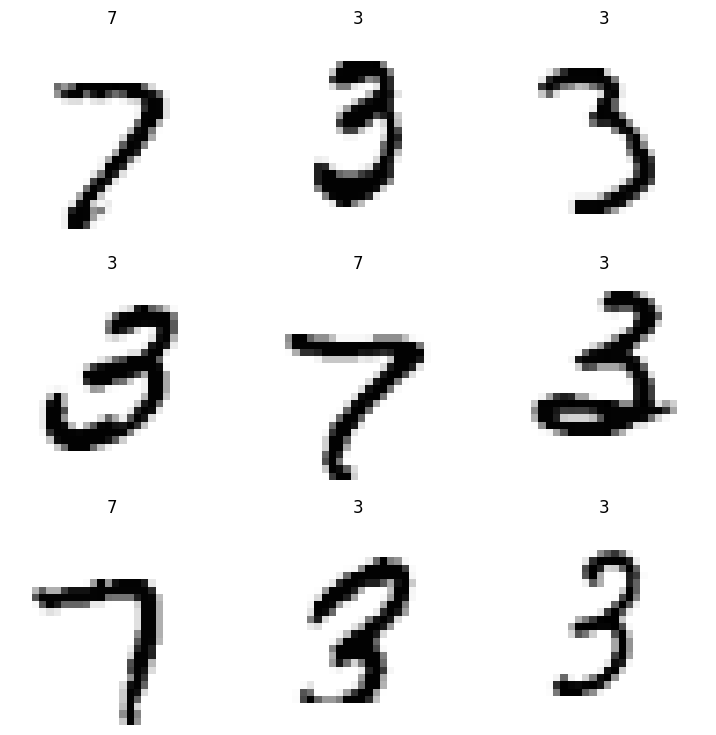

In [21]:
dls = mnist.dataloaders (untar_data(URLs.MNIST_TINY))
dls.show_batch()

Summary method will show step by step

In [22]:
mnist.summary(untar_data(URLs.MNIST_TINY))

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/7/8267.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/mnist_tiny/train/7/8267.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: ToTensor
Sett

## Multi-Label

Using Pascal Dataset

In [23]:
pascal_source = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(pascal_source/"train.csv")

In [24]:
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

Data uses one column for filenames, one for labels (seperated by a space) and one for validation.

Questions to API:
* What is the types of your inputs/targets?  (blocks =)
  * Images and multiple labels
* Where is your data? (get_items =)
  * dataframe, unneccessary since data is in one place
* Does something need to be applied to inputs? (get_x =)
  * column fname
* Does something need to be applied to the target? (get_y =)
  * column labels
* How to split the data? (splitter =)
  * column is_valid
* Do we need to apply something on formed items? (item_tfms =)
  * resize
* Do we need to apply something on formed batches? (batch_tfms)
  * Data augmentation

API:

In [25]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader(0, pref=pascal_source/"train"),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

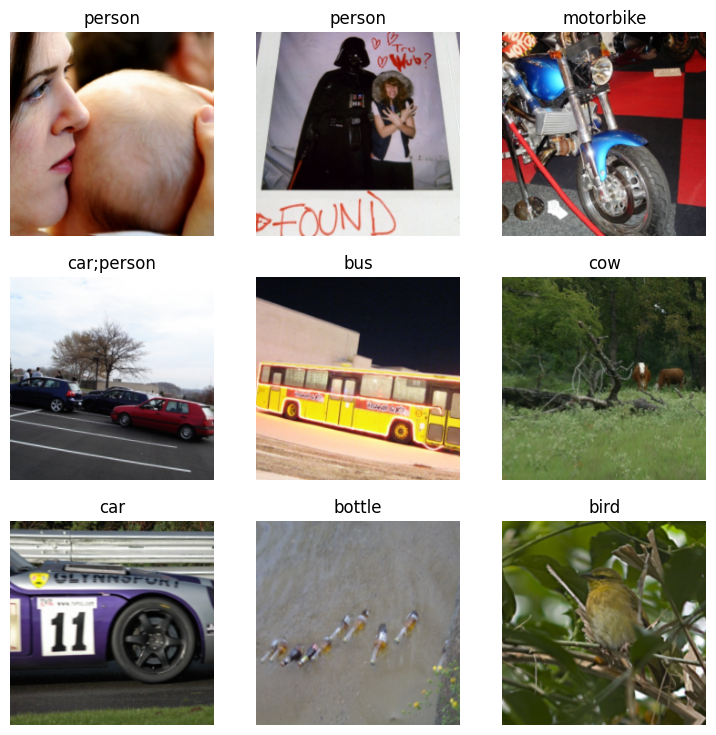

In [26]:
dls = pascal.dataloaders(df)
dls.show_batch()

Another method using using functions for get_x and get_y:

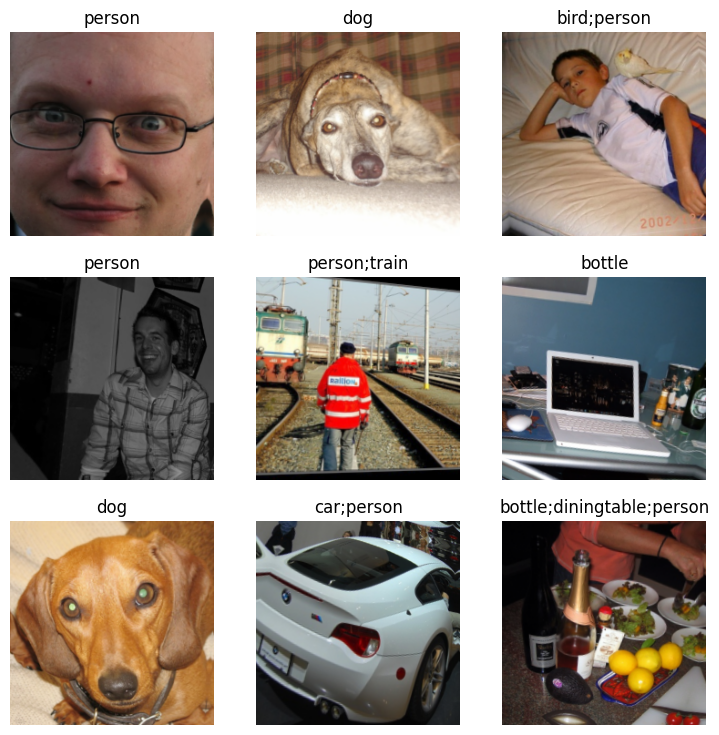

In [27]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda x:pascal_source/"train"/f'{x[0]}',
                   get_y=lambda x:x[1].split(' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

Another method using column names as attributes (since dataframe rows are pandas series):

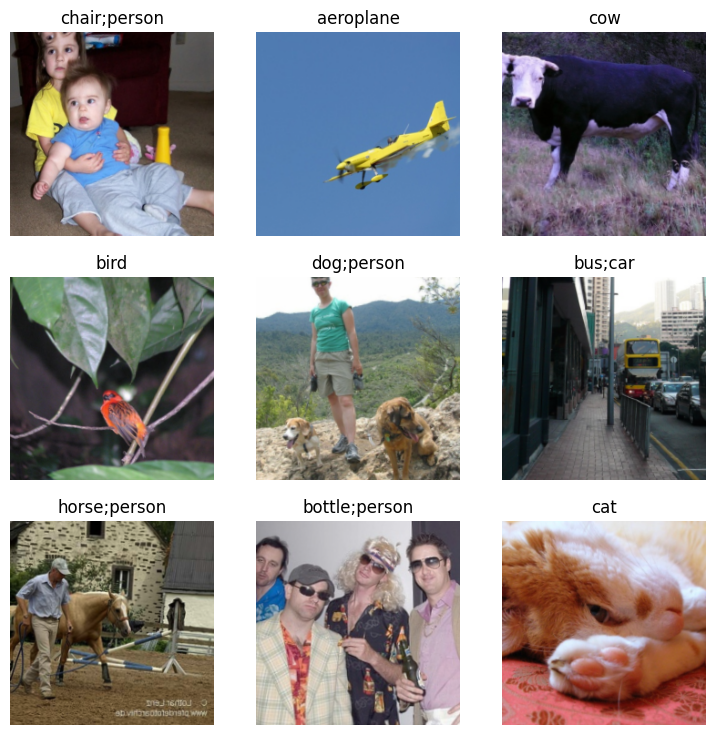

In [28]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda o:f'{pascal_source}/train/'+o.fname,
                   get_y=lambda o:o.labels.split(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

The most efficient method (to avoid irerating over the rows of the dataframe) is using from_columns method. It will use get_items to convert columns into numpy arrays. The drawback is that after extracting the columns, ColSplitter can't be used. Here IndexSplitter is used after manually extracting the index of the validation set from the dataframe:

In [29]:
def _pascal_items(x): return (
    f'{pascal_source}/train/'+x.fname, x.labels.str.split())
valid_idx = df[df['is_valid']].index.values

pascal = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_pascal_items,
                   splitter=IndexSplitter(valid_idx),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

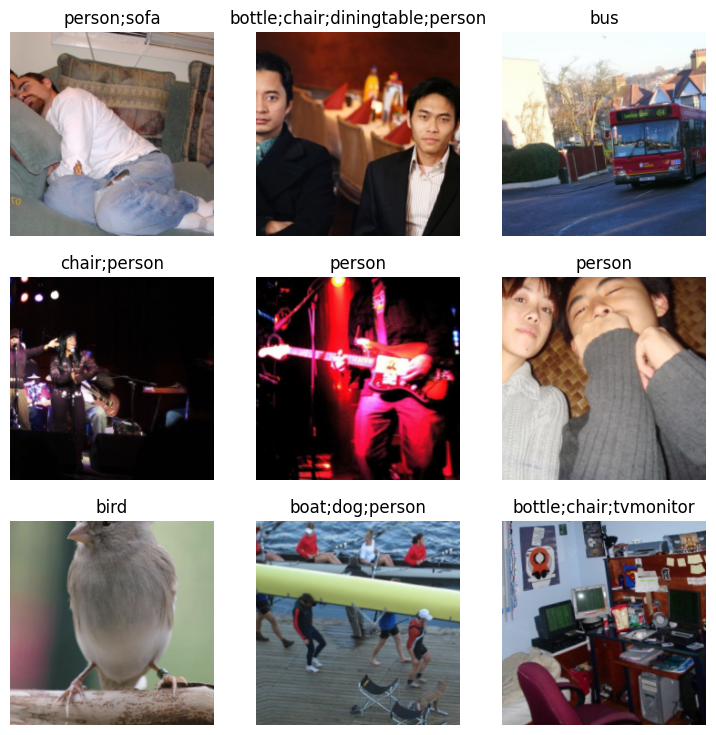

In [30]:
dls = pascal.dataloaders(df)
dls.show_batch()

# Image Localization

* Image Segmentation: Predicting class of each pixel in an image
* Coordinate Predictions: Predicting one or several key points of an image
* Object Detection: Drawing a box around objects to detect

In [2]:
from fastai.vision.all import *

## Segmentation

Usins a small subset of CamVid Dataset

In [3]:
path = untar_data(URLs.CAMVID_TINY)

Questions to API:
* What is the types of your inputs/targets?  (blocks =)
  * Images and segmentation masks
* Where is your data? (get_items =)
  * subfolders
* Does something need to be applied to inputs? (get_x =)
  * n/a
* Does something need to be applied to the target? (get_y =)
  * Labels folder
* How to split the data? (splitter =)
  * random split
* Do we need to apply something on formed items? (item_tfms =)
  * n/a
* Do we need to apply something on formed batches? (batch_tfms)
  * Data augmentation

API:

In [4]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

MaskBlock is generated with codes that coorespond between pixel value and object

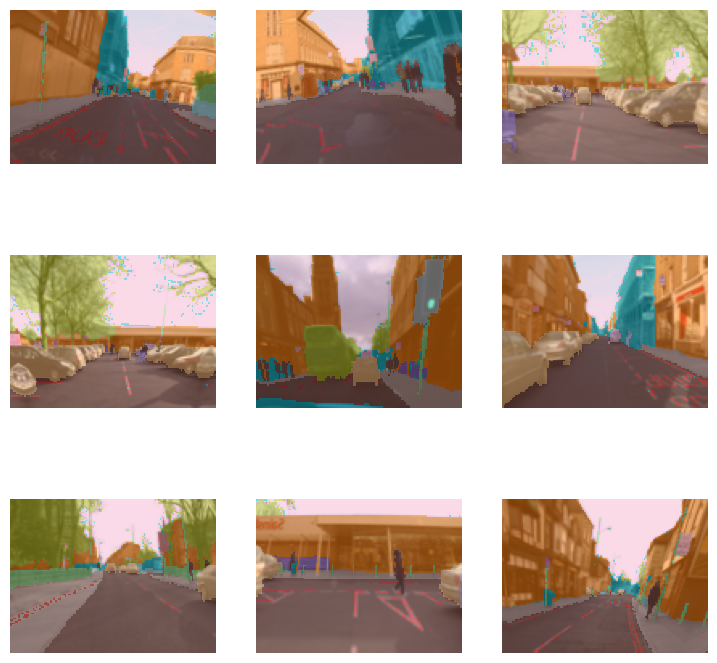

In [5]:
dls = camvid.dataloaders(path/"images")
dls.show_batch()

## Coordinate Predictions

Using small sample of BiWi kinect head pose dataset, saved with a dictionary filename

In [6]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = load_pickle(biwi_source/'centers.pkl')

Questions to API:
* What is the types of your inputs/targets?  (blocks =)
  * Images and points
* Where is your data? (get_items =)
  * subfolders
* Does something need to be applied to inputs? (get_x =)
  * n/a
* Does something need to be applied to the target? (get_y =)
  * Fn2ctr directory
* How to split the data? (splitter =)
  * random split
* Do we need to apply something on formed items? (item_tfms =)
  * n/a
* Do we need to apply something on formed batches? (batch_tfms)
  * Data augmentation

API:

In [7]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

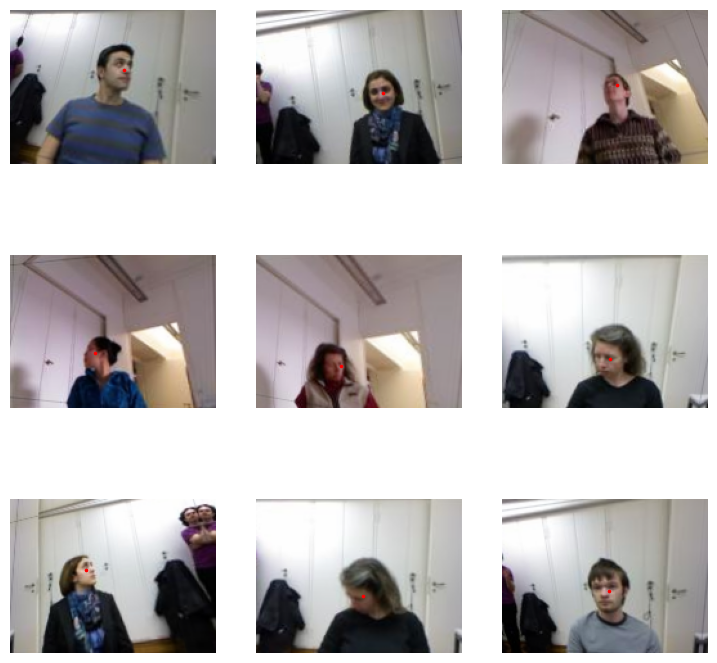

In [8]:
dls = biwi.dataloaders(biwi_source)
dls.show_batch(max_n=9)